In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [1]:
%matplotlib inline

In [10]:
import sys

import networkx as nx

sys.path.insert(0, 'gahyparopt/')

from gahyperopt import *

import ipywidgets as widgets
import os, shutil, shlex
import json, io
from subprocess import Popen, PIPE, STDOUT
from contextlib import redirect_stdout, redirect_stderr
from datetime import datetime
import pandas
import matplotlib as mpl
from matplotlib import pyplot
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
import glob
from collections import OrderedDict
import numpy

from GAUtilities import *

from parameters import *

In [11]:
def load_population():
    json_fnames = glob.glob("*.json")
    population = []
    names = []
    for j in json_fnames:
        name = j.split(".")[0]
        names.append(name)
        individuum = read_chromosome(j.split('.')[0])
        population.append(individuum)
        
    population = OrderedDict(zip(names, population))
    population=OrderedDict(sorted(population.items(),key=lambda x: x[1].accuracy, reverse=True))
    return population

In [12]:
POPULATION_SIZE=8

In [13]:
ga=GADriver(
            layer_counts=HIDDEN_LAYER_COUNT,
            no_neurons=HIDDEN_LAYER_NEURONS,
            rates=HIDDEN_LAYER_RATE,
            activations=HIDDEN_LAYER_ACTIVATIONS,
            layer_types=HIDDEN_LAYER_TYPE,
            optimizers=MODEL_OPTIMIZER,
            population_size=POPULATION_SIZE,
            best_candidates_count=BEST_CANDIDATES_COUNT,
            random_candidates_count=RANDOM_CANDIDATES_COUNT,
            optimizer_mutation_probability=OPTIMIZER_MUTATION_PROBABILITY,
            layer_mutation_probability=HIDDEN_LAYER_MUTATION_PROBABILITY,
        )

In [14]:
class model(object):
    generation_performance = {}
    population=None
    generations={}
    index=0

In [21]:
model = model()
model.population = load_population()

In [64]:
cmap = pyplot.cm.nipy_spectral  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey

# create the new map
segmented_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, POPULATION_SIZE)

segmented_cmap_list = [segmented_cmap(i) for i in range(segmented_cmap.N)]

# define the bins and normalize
bounds = np.linspace(0, POPULATION_SIZE, POPULATION_SIZE+1)
norm = mpl.colors.BoundaryNorm(bounds, POPULATION_SIZE)

players = model.population.keys()
color_player_dict = dict(zip(segmented_cmap_list, players))
player_color_dict = dict(zip(players, segmented_cmap_list))
# Add "0" for 0 generation
player_color_dict['0'] = "k"

In [84]:
def get_accuracy_plot(df):
    fig, ax = pyplot.subplots(2,1,sharex=True,figsize=(7,8))
    mn = df.accuracy.min()*0.9
    mx = min(df.accuracy.max()*1.1, 1.0)
    bar_width = 0.8
    df.iloc[::-1,::-1].plot.barh(x='name',
                                 y='accuracy',
                                 ax=ax[0],
                                 grid=True,
                                 color=color_player_dict
                                 )
    df['accuracy'].plot.hist(ax=ax[1],
                             grid=True,
                             bins=POPULATION_SIZE,
                             range=(mn,mx),
                             rwidth=bar_width,
                            )
    ax[1].set_xlim([mn,mx])
   
    return fig, ax


In [82]:
# Pull button
pull_button = widgets.Button(description="Generation aktualisieren")
def pull_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        sync_remote_to_local('all')
        
pull_button.on_click(pull_button_clicked)
#################################################################
#
# Generation count
generation_count = widgets.BoundedIntText(value=0, min=0, max=0)

def on_generation_count_change(change):
    log_widget.clear_output()
    with log_widget:
        df = model.generation_performance[change['new']]
        
    plot_accuracy_vs_name(df)
    plot_generation_tree()
    
generation_count.observe(on_generation_count_change, names=['value'])    
#################################################################
#
# Generation load button
generation_button = widgets.Button(description="Generation laden")

def generation_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        model.population = load_population()

        df = pandas.DataFrame([
            {'name': key,
             'loss': model.population[key].loss,
             'accuracy': model.population[key].accuracy
            } for key in model.population.keys()
        ])
        
        model.index = model.index + 1
        model.generation_performance.update({model.index: df})
        model.generations.update({model.index: model.population})
        generation_count.max = model.index
        generation_count.min = 1
        generation_count.value = model.index
    
generation_button.on_click(generation_button_clicked)
#################################################################
#
# Evolve button
evolve_button = widgets.Button(description="Evolution!")
def evolve_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        new_chromosomes = ga.evolve_population(list(model.population.values()))
        model.population = OrderedDict(zip(model.population.keys(), new_chromosomes))
        
evolve_button.on_click(evolve_button_clicked)
#################################################################
#
# Distribute button
distribute_button = widgets.Button(description="Generation verteilen")

def distribute_button_clicked(b):
    log_widget.clear_output()
    with log_widget:
        for name,individuum in model.population.items():
            write_chromosome(name=name,chromosome=individuum)
            sync_local_to_remote(name)
            
distribute_button.on_click(distribute_button_clicked)
#################################################################
#
# Plot widgets
accuracy_plot_widget = widgets.Output(layout={'border': '1px solid black', 'width':'50%', 'scroll':'true'})
generation_tree_widget = widgets.Output(layout={'border': '1px solid black', 'width':'50%', 'scroll':'true'})
log_widget = widgets.Output(layout={'border': '1px solid black', 'width':'80%', 'scroll':'true'})

def plot_accuracy_vs_name(df):
    accuracy_plot_widget.clear_output()
    with accuracy_plot_widget:
        
        fig, ax = get_accuracy_plot(df)

        show_inline_matplotlib_plots()
        
def plot_generation_tree():
    generation_tree_widget.clear_output()
    with generation_tree_widget:
        fig, ax = pyplot.subplots(1,1, figsize=(7,8))
        graph, pos = get_tree(model, generation_count.value)
        color = [player_color_dict[data["player"]] for v, data in graph.nodes(data=True)]
        nx.draw(graph, pos, ax, node_color=color)       
        show_inline_matplotlib_plots()
##################################################################
#
# GUI
gui = widgets.VBox(children=[
    widgets.HBox([pull_button, generation_button]),
    generation_count,
    widgets.HBox([
        accuracy_plot_widget,
        generation_tree_widget,
    ]),
    evolve_button,
    distribute_button,
    log_widget,
])

0.09805499687790871 1.0 0.8


(<Figure size 504x576 with 2 Axes>,
 array([<AxesSubplot:ylabel='name'>, <AxesSubplot:ylabel='Frequency'>],
       dtype=object))

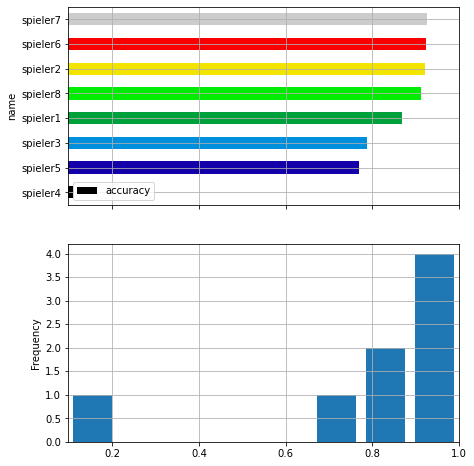

In [79]:
df = pandas.DataFrame([
    {'name': key,
     'loss': model.population[key].loss,
     'accuracy': model.population[key].accuracy
    } for key in model.population.keys()
])

get_accuracy_plot(df)

In [83]:
display(gui)

In [45]:
# Build graph
def get_tree(model, max_generation):
    
    graph = nx.DiGraph()
    graph.add_node("X-0", layer=0, player="0")
    
    for g,generation in model.generations.items():
        
        if g > max_generation:
            break
        for player, chrm in generation.items():
            graph.add_node("{}-{}".format(chrm.id, g), layer=g, player=player)


    edges = []

    for g,generation in model.generations.items():
        if g > max_generation:
            break
            
        for chrm in generation.values():
            parent_a = chrm.parent_a
            parent_b = chrm.parent_b
            id = chrm.id

            if parent_a is None and parent_b is None:
                parent_a = id
                parent_b = id

            if g == 1:
                parent_a = "X"
                parent_b = "X"

            parent_a = "{}-{}".format(parent_a, g-1) 
            parent_b = "{}-{}".format(parent_b, g-1) 

            if parent_a not in graph.nodes:
                parent_a = "{}-{}".format(id, g-1)
            if parent_b not in graph.nodes:
                parent_b = "{}-{}".format(id, g-1)

            id = "{}-{}".format(id, g)

            edges.append((parent_a, id))
            edges.append((parent_b, id))


    graph.add_edges_from(edges)

    nodes_to_remove = []
    for node,data in graph.nodes(data=True):
        if "layer" not in data.keys():
            nodes_to_remove.append(node)

    assert len(nodes_to_remove) == 0

    pos = nx.multipartite_layout(graph, subset_key="layer")

    return graph,pos

In [35]:
model.generations

{1: OrderedDict([('spieler7', <gahyperopt.Chromosome at 0x7efe8c058220>),
              ('spieler6', <gahyperopt.Chromosome at 0x7efe301cdd30>),
              ('spieler2', <gahyperopt.Chromosome at 0x7efe38089b20>),
              ('spieler8', <gahyperopt.Chromosome at 0x7efe301ec6a0>),
              ('spieler1', <gahyperopt.Chromosome at 0x7efe8c021400>),
              ('spieler3', <gahyperopt.Chromosome at 0x7efe380a7f10>),
              ('spieler5', <gahyperopt.Chromosome at 0x7efea46b7940>),
              ('spieler4', <gahyperopt.Chromosome at 0x7efe380454c0>)])}

In [54]:
graph, pos = get_tree(model, 1)

In [55]:
graph.nodes(data=True)

NodeDataView({'X-0': {'layer': 0, 'player': '0'}, 'zhdwgjyslhgf-1': {'layer': 1, 'player': 'spieler7'}, 'fbeuytdlvrpb-1': {'layer': 1, 'player': 'spieler6'}, 'nisblrjzcfyg-1': {'layer': 1, 'player': 'spieler2'}, 'udecivwogtlm-1': {'layer': 1, 'player': 'spieler8'}, 'sxkbjmewpzgw-1': {'layer': 1, 'player': 'spieler1'}, 'gajkzfmtgbbs-1': {'layer': 1, 'player': 'spieler3'}, 'ulikvpxqjoap-1': {'layer': 1, 'player': 'spieler5'}, 'rjggjbmzdnai-1': {'layer': 1, 'player': 'spieler4'}})

/home/grotec/.conda/envs/pydl-tf2.2/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


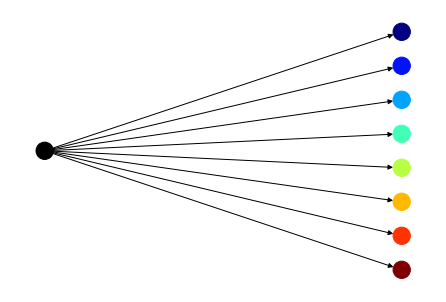

In [57]:
color = [player_color_dict[data["player"]] for v, data in graph.nodes(data=True)]
nx.draw(graph, pos, node_color=color)

In [ ]:
graph.nodes(data=True)

In [20]:
for g,generation in model.generations.items():
    print("Generation {}".format(g))
    for name,chromosome in generation.items():
        print("\t",name, chromosome.accuracy, chromosome.id, chromosome.parent_a, chromosome.parent_b)

Generation 1
	 spieler6 0.9370999932289124 fbeuytdlvrpb ymmzqxveiktl wvmlztimfbfu
	 spieler2 0.9323499798774719 muretoetzbfq None None
	 spieler3 0.9310500025749207 ymmzqxveiktl None None
	 spieler5 0.9247499704360962 hujbxchgfrcm wvmlztimfbfu muretoetzbfq
	 spieler1 0.9221000075340271 axpwdqqvxfik wvmlztimfbfu ymmzqxveiktl
	 spieler8 0.9219499826431274 wvmlztimfbfu None None
	 spieler4 0.9202499985694885 bglhjrfnldnh muretoetzbfq wvmlztimfbfu
	 spieler7 0.9157999753952026 zvccpfxrxpfq muretoetzbfq ymmzqxveiktl
Generation 2
	 spieler1 0.935949981212616 liymhdypjxzj muretoetzbfq fbeuytdlvrpb
	 spieler2 0.9296500086784363 muretoetzbfq None None
	 spieler6 0.9296500086784363 fbeuytdlvrpb ymmzqxveiktl wvmlztimfbfu
	 spieler7 0.9290000200271606 seksmcdzyykg muretoetzbfq fbeuytdlvrpb
	 spieler5 0.9269999861717224 lkjgfnaothtw muretoetzbfq fbeuytdlvrpb
	 spieler3 0.9240000247955322 hujbxchgfrcm wvmlztimfbfu muretoetzbfq
	 spieler8 0.9192500114440918 bplonfbfwulm hujbxchgfrcm fbeuytdlvrpb
	 sp

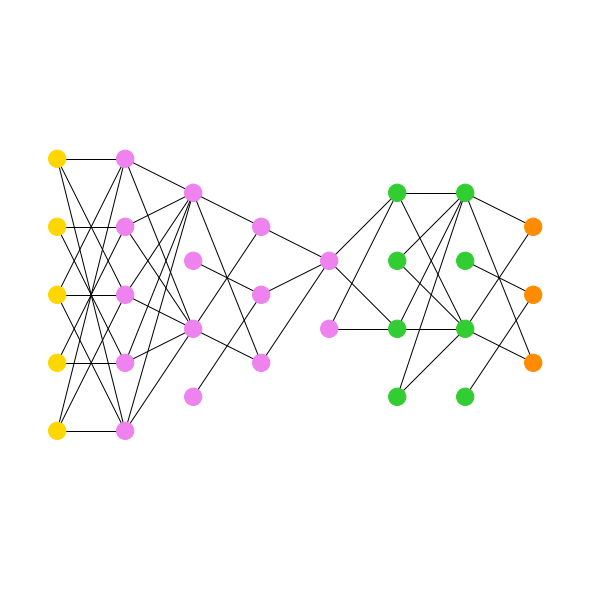

In [90]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        edges = itertools.product(layer1, layer2)
        edges = [edge for i,edge in enumerate(edges) if i%2==0]
        G.add_edges_from(edges)
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [ ]:
G.nodes(data=True)

In [ ]:
graph.nodes(data=True)

In [ ]:
pos = nx.multipartite_layout(graph, subset_key='generation')

In [ ]:
graph.nodes

In [ ]:
load_population()

In [ ]:
model.population

In [ ]:
for pl, ind in model.population.items():
    print(pl, ind.parent_a, ind.parent_b, ind.id)
    #ind.ml_model.summary()

In [ ]:
import newick

In [ ]:
# Generate tree
initial_population = model.generations[1]

In [ ]:
initial_population

In [ ]:
last_generation = model.generations[next(reversed(model.generations.keys()))]

In [ ]:
last_generation

In [ ]:
# Reverse-iterate through the generations and build up the tree.

In [ ]:
chromosome=  last_generation['spieler4']

In [ ]:
del model.generations[0]

In [ ]:
root = newick.Node.create(name="X")
# for gen in model.generations.values:
for indvdl_gen1 in model.generations[1].values():
    node_gen1 = newick.Node.create(name=indvdl_gen1.id)
    for indvdl_gen2 in model.generations[2].values():
        if indvdl_gen2.parent_a == indvdl_gen1.id:
            node_gen1.add_descendant(newick.Node.create(name=indvdl_gen2.id))
        elif indvdl_gen2.parent_b == indvdl_gen1.id:
            node_gen1.add_descendant(newick.Node.create(name=indvdl_gen2.id))
        elif indvdl_gen2.id == indvdl_gen1.id:
            node_gen1.add_descendant(newick.Node.create(name=indvdl_gen2.id))
            
#     parent_a = newick.Node.create(name=indvdl.parent_a)
#     parent_b = newick.Node.create(name=indvdl.parent_b)

#     node.add_descendant(parent_a)
#     node.add_descendant(parent_b)
    
    root.add_descendant(node_gen1)
    
    

In [ ]:
print(root.ascii_art())

In [ ]:
winner = newick.Node.create(name=next(reversed(model.generations)), descendants=None)

In [ ]:
for gen, pop in model.generations:
    
root.add_descendant(newick.Node(name='A'))

In [ ]:
model.generations[4]

In [ ]:
generation_count.value

In [ ]:
winner = model.generations[4]['B']; winner

In [ ]:
for gen in range(4,0,-1):
    for parent in 
    winner_node.add_descendant(parent.id)

In [ ]:
winner_node = newick.Node(name=winner.id)

In [ ]:
def add_parents(node, parent_gen):
    gen_dict = model.generations[parent_gen]
    chromosomes = list(gen_dict.values())
    
    parent_ids = 
    node.add_descendant()
    
    
    

In [ ]:
for gen, pop in model.generations.items():
    print(gen)
    if gen>0:
        print(pop['D'].id)
          

In [ ]:
model.generations